In [1]:
import os, sys
sys.path.insert(1, os.getcwd()+'/..')
if (os.path.basename(os.getcwd()) == 'tutorials'):
    os.chdir('../..')

from src.msa import generate
from src.msa.visualization import plot
from src.msa.feature_extraction import features

from mspc_pca.pca import *
from mspc_pca.omeda import *
from mspc_pca.mspc import *
from mspc_pca.ckf import *
import mspc_pca.plot as pca_plot

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# %matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')
%matplotlib qt


#### Ilustrative example of a chirp pulse

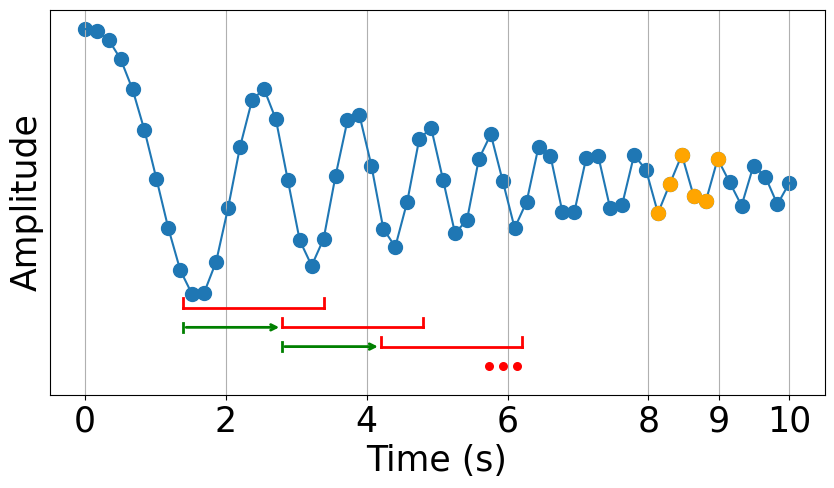

In [2]:
%matplotlib inline
from matplotlib.patches import Rectangle
sr = 6
T = 10
window_size = 2#s
window_shift = 1.4#s


# Tiempo y señal
time = np.linspace(0, T, int(sr * T))
signal = generate.chirp(time, 1, 0, 2, -1, 10, 'linear', -45) * generate.decay(time, 0.2, -1)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(time, signal, label="Samples", s=100)
ax.plot(time, signal)
ax.scatter(time[int(8*sr):int(9*sr)], signal[int(8*sr):int(9*sr)], s=100, color='orange', zorder=3)
# ax.legend(fontsize=20)
ax.set_ylabel("Amplitude", fontsize=25)
ax.set_yticks([])
ax.set_ylim(-1.1, 0.9)
ax.set_xlabel("Time (s)", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
xticks = ax.get_xticks()
if 9 not in xticks:
    xticks = list(xticks) + [9]
    xticks = sorted(set(xticks))  # eliminar duplicados y ordenar
ax.set_xticks(xticks)
# ax.set_xticks([])
ax.grid()
# ax.set_title("Pulsed chirp", fontsize = 25)

# Dibujar cajas sin tapadera debajo de la señal
y_bottom = -1 +0.45
y_top = -0.95 +0.45
step = 0.1
for i in range(1,4):
    y_bottom = y_bottom -step
    y_top = y_top -step

    start = i * window_shift
    end = start + window_size

    # Línea izquierda
    ax.plot([start, start], [y_bottom, y_top], color='red', linewidth=2)
    # Línea base
    ax.plot([start, end], [y_bottom, y_bottom], color='red', linewidth=2)
    # Línea derecha
    ax.plot([end, end], [y_bottom, y_top], color='red', linewidth=2)


# Añadir puntos suspensivos (tres puntos rojos)
dots_y = y_bottom-0.1  # misma altura que la base de la última caja
dots_x_start = end - window_shift/3  # justo después del final de la tercera caja

dot_spacing = .2
dots_x = [dots_x_start + i * dot_spacing for i in range(3)]
ax.scatter(dots_x, [dots_y] * 3, color='red', s=30)

# Añadir flechas verdes entre las cajas con "patita" al inicio
arrow_y = y_bottom +.20  # Y debajo de la última caja
tick_height = 0.025  # altura de la "patita"

for i in range(1,3):  # Solo entre cajas 0→1 y 1→2
    arrow_y = arrow_y -0.1
    start = i * window_shift
    next_start = (i + 1) * window_shift

    # Flecha horizontal
    ax.annotate(
        '',
        xy=(next_start, arrow_y),
        xytext=(start, arrow_y),
        arrowprops=dict(arrowstyle='->', color='green', linewidth=2)
    )

    # "Patita" vertical en el inicio
    ax.plot([start, start], [arrow_y - tick_height, arrow_y + tick_height], color='green', linewidth=2)

plt.show()

#### Generate synthetic signal

(<Figure size 640x480 with 1 Axes>, <Axes: >)

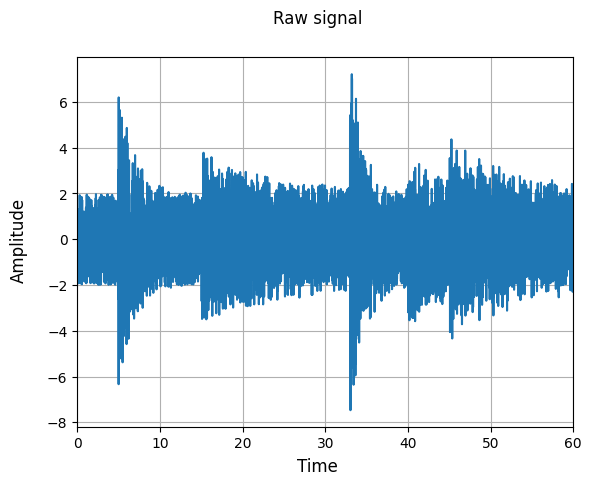

In [3]:
T = 60 #s. Duration in secods
sr = 100 # Sampling rate
n_samples = int(T*sr)

time = np.linspace(0,T, n_samples)

# Generate Chirps
chirp = np.zeros_like(time)
# chirp  += generate.chirp(time, A=1.0, f0=0.0, f1=50., t0=1. ,t1=60 ,method='linear',phi=0)*generate.decay(time, 0.0, 1.)
# chirp  += generate.chirp(time, A=1.0, f0=50., f1=0.0, t0=1. ,t1=60 ,method='linear',phi=0)*generate.decay(time, 0.0, 1.)
# chirp  += generate.chirp(time, A=4.0, f0=40., f1=10., t0=10 ,t1=25 ,method='linear',phi=0)*generate.decay(time, 0.5, 10)
# chirp  += generate.chirp(time, A=1.5, f0=10., f1=15., t0=25 ,t1=30 ,method='linear',phi=0)*generate.decay(time, 0.1, 25)

chirp  += generate.chirp(time, A=5.0, f0=45., f1=15., t0=5. ,t1=6. ,method='linear',phi=0)*generate.decay(time, 0.5, 5.) # F falls qucikly in time
chirp  += generate.chirp(time, A=6.0, f0=0., f1=30, t0=33 ,t1=33.1 ,method='linear',phi=0)*generate.decay(time, 0.6, 33) # F grows quickly in time

chirp  += generate.chirp(time, A=2.0, f0=25., f1=25.1, t0=15 ,t1=35 ,method='linear',phi=0)*generate.decay(time, 0.1, 15) # F grows slowly in time
chirp  += generate.chirp(time, A=2.0, f0=45., f1=44.9,t0=40 ,t1=60 ,method='linear',phi=0)*generate.decay(time, 0.2, 40) # F falls slowly in time

chirp  += generate.chirp(time, A=2.0, f0=15., f1=20,t0=45 ,t1=50 ,method='linear',phi=0)*generate.decay(time, 0.1, 45) 

# Generate white noise
A = 2
np.random.rand(123)
white = np.random.rand(int(T*sr))*A*2 - A

# Synthetic signal
signal = chirp + white 

plot.signal(time, signal)

#### Spectrograms: Parameters

**samplig rate (sr)**: Sampling rate is often fixed by our sensors. Via Nyquist, it determines the maximum frequency we can observe.

**window size**: Longer windows provide better frequency resolution and worse temporal resolution.

**shift**: Shorter shifts provide better temporal resolution.

**nº of bins**: Number of different frequencies to consider for the FFT. Its value should be equal to the number of samples per window. If lower, the frequency resolution will deminish.


Text(0.025, 0.025, '')

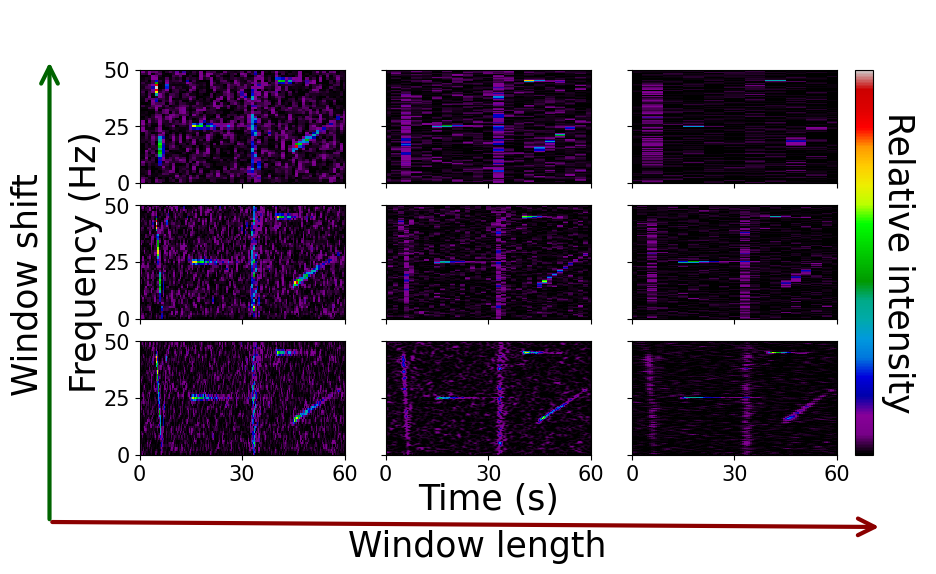

In [4]:
# Parameters

sr = sr #Hz. 
window_sizes = [1, 3, 6] #s. 
shift_fractions = [1.0, 0.5, 0.1]#s. 
n_bins = None # 


scale = False
if scale:
    vmin = 0
    vmax = 100000.0
    norm = vmax-vmin
else: vmin, vmax, norm = None, None, 1

fig, ax, _ = plot.grid(len(window_sizes), len(shift_fractions), text0=fr"Window size", text1=rf"Window shift", figsize=(9,5), x0=0.04, x1=0.94)

N = len(window_sizes)
M = len(shift_fractions)

times = [[[] for _ in range(M)] for _ in range(N)]
freqs = [[[] for _ in range(M)] for _ in range(N)]
Sxxs  = [[[] for _ in range(M)] for _ in range(N)]


for n, window in enumerate(window_sizes):
    for m, shift_fraction in enumerate(shift_fractions):
            win_samples = int(sr*window)
            hop = int(win_samples*shift_fraction)
            time, freq, Sxx = features.spectrogram(signal, sr, win_samples, hop, "blackman","zeros", "linear")

            # Eliminate padded times
            mask = (time >=0) & (time <=T)
            time = time[mask]
            Sxx = Sxx[:, mask]

            times[n][m] = time
            freqs[n][m] = freq
            Sxxs[n][m] = Sxx

            _, _ , mesh = plot.spectrogram(time, freq, Sxx/norm, (0,T), (0,sr/2), "nipy_spectral", False, vmin, vmax, ax = ax[m,n], logscale=False)

            ax[m,n].set_xticks([0,30,60])
            ax[m,n].tick_params(axis='x', labelsize=15)
            ax[m,n].set_yticks([0,25,50])
            ax[m,n].tick_params(axis='y', labelsize=15)



bbox = ax[-1, -1].get_position()
tbox = ax[ 0, -1].get_position()
cax = fig.add_axes([0.92, bbox.y0, 0.02, tbox.y1-bbox.y0])  # [left, bottom, width, height] en coords de figura
cbar = fig.colorbar(mesh, cax=cax)
cbar.ax.set_yticks([])      
cbar.ax.set_yticklabels([])
cbar.set_label("Relative intensity", rotation=270, labelpad=30, fontsize=25)




ax[-1,1].set_xlabel("Time (s)", fontsize=25, labelpad=-1.5);
ax[1,0].set_ylabel("Frequency (Hz)", fontsize=25, labelpad=0);

x0=0.025
x1=0.95

fig.text(0.5, -0.025, "Window length", ha='center', va='center', fontsize=25)    
fig.text(0, 0.5, "Window shift", ha='center', va='center', rotation=90, fontsize=25)  

offset = 0.05  # amount to move up (in figure coordinates)

ax_aux = fig.add_axes([0, 0, 1, 1], zorder=-1)
ax_aux.axis("off")
ax_aux.annotate('',xytext=(x0,x0-offset), xy=(x0,x1-0.05), # start, end (arrow)
                arrowprops=dict(arrowstyle='->', linewidth=3, mutation_scale=30, color='darkgreen'))

for ax_i in fig.axes:
    pos = ax_i.get_position()  # Bbox(x0, y0, x1, y1)
    new_pos = [pos.x0, pos.y0 + offset, pos.width, pos.height]
    ax_i.set_position(new_pos)

ax_aux = fig.add_axes([0, 0, 1, 1], zorder=-1)
ax_aux.axis("off")
ax_aux.annotate('',xytext=(x0,x0), xy=(x1,x0-0.01), # start, end (arrow)
                arrowprops=dict(arrowstyle='->', linewidth=3, mutation_scale=30, color='darkred'))
    

# offset=-offset
# pos = ax_aux.get_position()  # Bbox(x0, y0, x1, y1)
# new_pos = [pos.x0, pos.y0 + offset, pos.width, pos.height]
# ax_aux.set_position(new_pos)

#### PCA Visualization

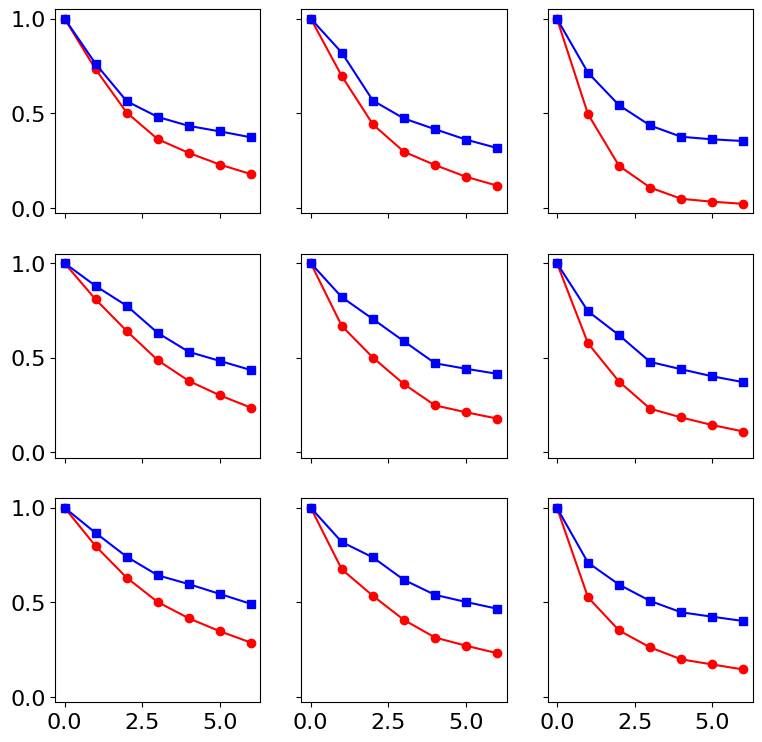

In [5]:
autoscale = False


fig, ax, ax_aux = plot.grid(len(window_sizes), len(shift_fractions), text0=fr"Window size", text1=rf"Window shift", figsize=(9,9), )

for n, window in enumerate(window_sizes):
    for m, shift_fraction in enumerate(shift_fractions):
        Sxx = Sxxs[n][m]
        data = Sxx.T
        scaler = StandardScaler(with_std=autoscale)
        data_norm = scaler.fit_transform(data)
        pca_plot.var_pca(data, 6, autoscale, ax = ax[m,n])
        ax[m, n].set_title('')
        ax[m, n].set_xlabel('')
        ax[m, n].set_ylabel('')

        # Remove legend (if present)
        legend = ax[m, n].get_legend()
        if legend is not None:
            legend.remove()


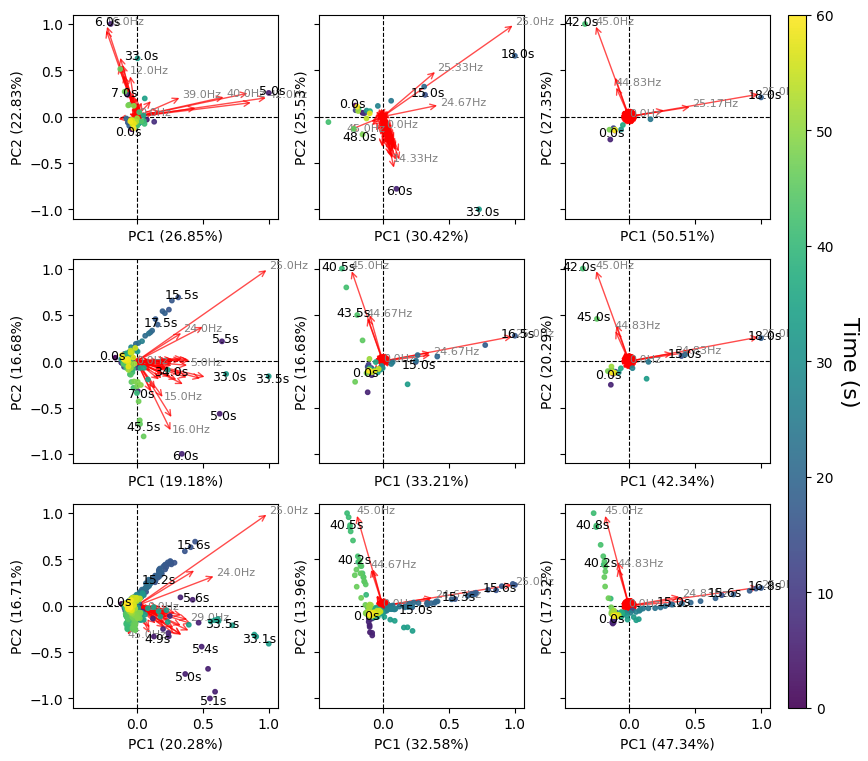

In [6]:
pca = PCA(n_components=2)

fig, ax, ax_aux = plot.grid(len(window_sizes), len(shift_fractions), text0=fr"Window size", text1=rf"Window shift", figsize=(9,9), )

for n, window in enumerate(window_sizes):
    for m, shift_fraction in enumerate(shift_fractions):
        Sxx = Sxxs[n][m]
        data = Sxx.T
        scaler = StandardScaler(with_std=autoscale)
        data_norm = scaler.fit_transform(data)
        freqs_label = [f"{round(x, 2)}Hz" for x in freqs[n][m]]
        times_label = [f"{round(x, 2)}s" for x in times[n][m]]
        _,_,scatter = pca_plot.biplot(data_norm, pca, 1, 2, label_dist=0.3, score_labels=times_label, loading_labels=freqs_label, score_classes=times[n][m], size=10, ax=ax[m,n])
        ax[m, n].set_title('')
        # ax[m, n].set_xlabel('')
        # ax[m, n].set_ylabel('')

        # Remove legend (if present)
        legend = ax[m, n].get_legend()
        if legend is not None:
            legend.remove()



bbox = ax[-1, -1].get_position()
tbox = ax[ 0, -1].get_position()
cax = fig.add_axes([0.92, bbox.y0, 0.02, tbox.y1-bbox.y0])  # [left, bottom, width, height] en coords de figura
cbar = fig.colorbar(scatter, cax=cax)
# cbar.ax.set_yticks([])      
# cbar.ax.set_yticklabels([])
cbar.set_label("Time (s)", rotation=270, labelpad=18, fontsize=16)

[array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
         6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
         8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
        10.        , 10.33333333, 10.66666667, 11.        , 11.33333333,
        11.66666667, 12.        , 12.33333333, 12.66666667, 13.        ,
        13.33333333, 13.66666667, 14.        , 14.33333333, 14.66666667,
        15.        , 15.33333333, 15.66666667, 16.        , 16.33333333,
        16.66666667, 17.        , 17.33333333, 17.66666667, 18.        ,
        18.33333333, 18.66666667, 19.        , 19.33333333, 19.66666667,
        20.        , 20.33333333, 20.66666667, 21.        , 21.33333333,
        21.66666667, 22.        , 22.33333333, 22.6